In [3]:
%matplotlib inline 
import numpy as np
import pandas as pd 
import scipy
import scipy.integrate as integrate
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 
import colossus
import numba as nb
sns.set_style("darkgrid")

# Halo Mass Function 
We used the online HMF calculator to get the halo mass distribution at different redshift (website: http://hmf.icrar.org)

In here, we extract the data of halo mass function when $z = 0.5, 2, 4$. The data is shown as below. With the data of comoving number density of halo mass per unit mass and corresponding halo mass at certain redshift, we may use this information to calculate the total lensing cross-section. In here, we used Pandas to read the files which are downloaded in HMFcalc. 

In [129]:
hmf_00= pd.read_csv("tinker_08_z_00.txt",skiprows=range(12), sep=' ',
            names=['m', 'sigma', 'ln(1/sigma)', 'n_eff', 'f(sigma)', 'dn/dm', 'dn/dlnm', 'dn/dlog10m', 'n(>m)',
                   'rho(>m)', 'rho(<m)', 'Lbox(N=1)'])

In [131]:
m = hmf_00["m"]

# Colossus: Generating Halo Mass Function for Different Redshifts
In this code, we use Colossus to generate the halo mass function at different redshifts. When we calculate the total lensing cross-section, we need to know the number of available lenses in the universe at a particular instance. Therefore, we need to use Colossus to generate a comoving number density of haloes per its mass in redshift $z_{L}$ for a given mass range. 

website of Colossus: http://www.benediktdiemer.com/code/colossus/

In [5]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function

cosmology.setCosmology('planck13')
mfunc_fof = mass_function.massFunction(m,z =0.0 , q_in= "M", q_out="dndlnM", mdef='vir', model = 'tinker08')

# Total Lensing Cross-section

The total lensing cross-section is given by the sum of available lenses at the universe at particular instant and its cross-section. Therefore, we need to (total number/ number density, etc) of available lenses at a certain redshift. In this code, we use the comoving number density of haloes per its logarithm of mass. In order to understand the total lensing cross-section for a source, we can imagine the physical picture as follow: 

Suppose we have a gravitational waves source from redshift $z_{S}$. When it is emitted from $z_{S}$, it will pass through the universe and approaching to us $z = 0$. However, during its propagation, it will pass through haloes in the universe, resulting in graviational lensing. Therefore, our job is to calculating the total lensing cross-section of gravitatinal waves source originates from $z_{S}$ which is the sum of the lensing cross-section of each hales at different lenses redshifts $z_{L} \in (0, z_{S})$.The equation of total lensing cross-section is given by the follow: 
\begin{equation}
\sigma^{S}_{total}(\mu,z_{S}) =  \frac{8 \pi^{3} G^{2}}{c^{4}}\frac{(\mu_{0}^{2}+1)}{(\mu_{0}^{2} -1)^{2}} \int^{z_{S}}_{0} \int_{\Omega_{M}} \frac{dn(M,z_{L})}{d \ln{M}} \Big( \frac{M}{r_{200}} \Big)^{2}\Big( \frac{d_{A}(z_{L},z_{S})}{d_{A}(z_{s})} \Big)^{2} d\ln{M} dV(z_{L})
\end{equation}
$\Omega_{M}$ is the integral domain of mass of available lenses in particular lens redshift $z_{L}$.  This lensing cross-section will tell us the relevant probability of a gravitational waves source in $z_{S}$ will be maginified by $\mu$.

In astropy Libary, we can call cosmo.differential_comoving_volume(z) to calculate the differential volume. However, the unit of differential comoving volume is in volume per solid angle per redshift. Therefore, when we need to calculate the integral of differential volume, we are in fact calculating this:
\begin{equation}
dV = 4 \pi \Big(\frac{dV}{d \Omega dz} \Big)_{astropy} dz
\end{equation}

Hence, the equation becomes:
\begin{equation}
\sigma^{S}_{total}(\mu,z_{S}) =  \frac{8 \pi^{3} G^{2}}{c^{4}}\frac{(\mu_{0}^{2}+1)}{(\mu_{0}^{2} -1)^{2}} \int^{z_{S}}_{0} \int_{\Omega_{M}} \frac{dn(M,z_{L})}{d \ln{M}} \Big( \frac{M}{r_{200}} \Big)^{2}\Big( \frac{d_{A}(z_{L},z_{S})}{d_{A}(z_{s})} \Big)^{2} d\ln{M}  \Big(4 \pi \Big(\frac{dV}{dz_{L}} \Big) \Big)dz_{L}
\end{equation}

In [88]:
# Using Astropy to calculate the total lensing cross section of source plane 
import astropy 
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
#cosmo = FlatLambdaCDM(H0=70*u.km/u.s/u.Mpc, Om0=0.3)
c = 3E8
G = 6.6748E-11
H_0 = cosmo.H(0)
from colossus.halo import mass_so

def Hubble(z): 
    return H_0*np.sqrt(0.307*(1+z)**3 + 0.693)

#Assume Virial mass
def r_200(m,zl): 
    return (m*G/(100*Hubble(zl)**2))**(1/3)

### Colossus R_200c 
def R_200c(m,zl):
    #return np.array([mass_so.M_to_R(m, i, '200c') for i in zs])
    return mass_so.M_to_R(m, zl, '200c')

# Differential Mass
def dlnm(m):
    # Change 0 into last position inside array
    dM = np.append(np.array([(np.log(m[i+1])-np.log(m[i]))/len(m) for i in range(0,len(m)-1)]), np.array([(np.log(m[11])-np.log(m[10]))/len(m)]))
    return dM

# Comoving Number density of Haloes per ln(Haloes Mass)
def dndlnm(m,zl):
    mfunc_fof = mass_function.massFunction(m,z=zl , q_in= "M", q_out="dndlnM", mdef='200c', model = 'tinker08')
    return mfunc_fof



# total lensing cross secion (in dn/dlnm unit)
def total_cross_sec(m,zl,zs):
    # 2 for loops: 
    
    ### We need to add a if statement that z_{L} < z_{S}
    ### for a source in Z_{s}, the available lenses are in z_{L} < z_{S}, thus, we sum over the z_{l} from 0 to z_{S}
    # For a particular lens redshift, we sum over all the contribution of these lenses
    cross_sec = np.array([np.sum(np.asarray([(8*np.pi**3*G**2*c**-4)*dlnm(m)*dndlnm(m,i)*(m/R_200c(m=m,zl=i)*cosmo.comoving_volume(i)*(cosmo.angular_diameter_distance_z1z2(i,j)/cosmo.angular_diameter_distance(j)))**2\
                       for i in zl])) for j in zs])
    return cross_sec


### Total Cross-section: integrate all the available lenses 
# def cs(m,zs): 
#     ### USE R_200C instead of virial mass r_200
#     ### Inner Loop: we integrate the total lens contribution in range zl \in (0,zs) for a given zs ###
#     ### Outer Loop: For each source redshift zs, we want to find the total lensing cross-section at zs ###
#     cross_sec = np.array([np.sum(np.asarray([(8*np.pi**3*G**2*c**-4)*dlnm(m)*dndlnm(m,i)*cosmo.differential_comoving_volume(i)*(m/R_200c(m=m,zl=i))**2*((cosmo.angular_diameter_distance_z1z2(i,j)/cosmo.angular_diameter_distance(j)))**2\
#                        for i in np.linspace(0,j,len(zs))])) for j in zs])
#     return cross_sec 


In [89]:
G**2*c**-4

5.500364819753086e-55

In [126]:
const = (32*np.pi**4*G**2*c**-4)

def mu_gw(zs):
    # zs > 0.3 by computation
    return (cosmo.luminosity_distance(zs)/cosmo.luminosity_distance(0.15))**2 

def sigma_4(m,zs):
    array = np.zeros(1000)
    k = 0
    for i in np.linspace(0,zs,1000):
        haloes = const*np.sum(dlnm(m)*dndlnm(m,i)*(m/R_200c(m,i))**2)
        cs = cosmo.differential_comoving_volume(i)*(cosmo.angular_diameter_distance_z1z2(i,zs)/cosmo.angular_diameter_distance(zs))**2
        array[k] = haloes*cs.value
        k+= 1
        # (mu_gw(zs)**2+1)*(mu_gw(zs)**2 - 1)**-2*
    return np.sum(array)

In [128]:
#sigma = np.array([sigma_4(m,i) for i in np.linspace(0.1,5,50)])

In [ ]:
#plt.plot(mu_gw(np.linspace(0.15,5,50)), sigma)


In [ ]:
### Total Cross-section: integrate all the available lenses 


# def cs(m,zs): 
#     ### integrate dV = 4*pi*dV*delta z, since dV in unit of volume per redshift per solid angle
#     ### Use R_200C instead of virial mass r_200
#     ### Inner sum ( sum over all the mass) ( appended in 3/5 )
#     ### Inner Loop: we integrate the total lens contribution in range zl \in (0,zs) for a given zs ###
#     ### Outer Loop: For each source redshift zs, we want to find the total lensing cross-section at zs ###
#     cross_sec = np.array([np.sum(np.asarray([(8*np.pi**3*G**2*c**-4)*np.sum(dlnm(m)*dndlnm(m,i))*\
#                                              (4*np.pi*cosmo.differential_comoving_volume(i)*j*len(zs)**-1)*\
#                                              (m/R_200c(m=m,zl=i))**2*\
#                                              ((cosmo.angular_diameter_distance_z1z2(i,j)/cosmo.angular_diameter_distance(j)))**2\
#                        for i in np.linspace(0,j,len(zs))])) for j in zs])
    
#     return cross_sec 

In [8]:

# ### For Loops method
# def cs_1(m,zs): 
#     k = 0 
#     array = np.zeros(len(zs))
#     # Range of source redshift
#     for j in zs: 
#         # for particular source redshift, we need to sum over the contribution of lenses z_{L} \in (0,z_{S})
#         TCS = 0
#         for i in np.linspace(0,j,len(zs)):
#             # Sum all lenses mass in particular z_{L}
#             cs = np.sum((8*np.pi**3*G**2*c**-4)*dlnm(m)*dndlnm(m,i)*\
#                         (4*np.pi*cosmo.differential_comoving_volume(i)*len(zs)**-1)*(m/R_200c(m=m,zl=i))**2*\
#                         ((cosmo.angular_diameter_distance_z1z2(i,j)/cosmo.angular_diameter_distance(j)))**2)
#             TCS+=cs   
#         #print(TCS)
#         array[k] = TCS
#         ##print(array[k])
#         k+=1
#     return array
            
                   

In [50]:
### another method using loops 

# def sigma_2(m,zs):
#     const = 32*np.pi**4*G**2*c**-4
#     zl = np.linspace(0,zs,1000)
#     TCS = 0
#     for i in range(len(zl)):
#         ### summation of haloes density, dlnm, etc as a particular lenses redshift z_{L}
#         haloes = np.sum(dndlnm(m,zl[i])*(m/R_200c(m,zl[i]))**2*dlnm(m))
#         ### second summation of all lenses ranges from 0 to z_{S}, act as an integrtion of z_{L}
#         delta_zl = (zs-0)/len(zl)
#         cs = haloes*(cosmo.differential_comoving_volume(zl[i]).value)*\
#         ((cosmo.angular_diameter_distance_z1z2(zl[i],zs).value/cosmo.angular_diameter_distance(zs).value))**2*delta_zl
#         TCS += cs
#     return const*TCS

In [56]:
### another method using loops

# def sigma_3(m,zs):
#     zl = np.linspace(0,zs,10000)
#     return  32*np.pi**4*G**2*c**-4*np.sum(np.array([np.sum(dndlnm(m,i)*(m/R_200c(m,i))**2*dlnm(m))*\
#              (cosmo.differential_comoving_volume(i).value)*\
#              (cosmo.angular_diameter_distance_z1z2(i,zs).value/cosmo.angular_diameter_distance(zs).value)**2*
#              zs*len(zl)**-1 for i in zl]))

In [48]:
### integration version using Scipy

# def sigma_integrate(m,zs):
#     const = 32*np.pi**4*G**2*c**-4
#     result = integrate.quad(lambda x:np.sum(dndlnm(m,x)*(m/R_200c(m,x)**2*dlnm(m))*\
#                             (cosmo.differential_comoving_volume(x).value)*\
#                             ((cosmo.angular_diameter_distance_z1z2(x,zs).value/cosmo.angular_diameter_distance(zs).value))**2)
#                             , 0,zs)
                            
#     return const*result[0]




#@nb.jit(nopython=True)
def sigma_integrate(zs):
    f = lambda m,x,zs: dndlnm(m,x)*(m/R_200c(m,x)**2)*\
                             (cosmo.differential_comoving_volume(x).value)*\
                             (cosmo.angular_diameter_distance_z1z2(x,zs).value/cosmo.angular_diameter_distance(zs).value)**2
    return integrate.nquad(f, [[0.0, np.inf],[0.0001, zs]],args=[zs])[0]

In [65]:
# Gws source range z_{S} = 0.01 ~ 5 since z_{L} < z_{S}
zs = np.linspace(0.001,300,10)

In [66]:
#sigma_3(m,1)

In [67]:
cross_sec = np.asarray([sigma_3(m,j) for j in zs])
#10:100
#20: 94
#50:97
#70:95
#100:93

KeyboardInterrupt: 

In [ ]:
plt.plot(zs,cross_sec)
plt.title(r"Total Lensing Cross-section vs Source Redshift $z_{S}$ ")
plt.ylabel(r" Total Lensing Cross-section $(\mu_{0}^{2}-1)^{2}/(\mu_{0}^{2} + 1)$")
plt.xlabel(r" Source Redshift $z_{S}$")
plt.savefig("cross_sec_vs_z.pdf")

In [178]:
cs_vs_z = pd.DataFrame({"zs":zs, "sigma":cross_sec})
cs_vs_z[cs_vs_z["sigma"]== np.max(cs_vs_z["sigma"])]

,zs,sigma
9,5.0,2.959431e-36


In [121]:
# Maginification of Gravotational waves 
def mu_gw(zs):
    # zs > 0.3 by computation
    return (cosmo.luminosity_distance(zs)/cosmo.luminosity_distance(0.15))**2 

In [123]:
np.sqrt(mu_gw(95.652855))

<Quantity 1682.60005919>

In [24]:
### cross-section where mu_{GW} is not a constant, it is a function depending on z_{S}
def cs_mu(m,zs): 
    ### May choose dV = 4*pi*dV *delta z
    ### What is the differences of using dV and V ???? 
    ### Inner Loop: we integrate the total lens contribution in range zl \in (0,zs) for a given zs ###
    ### Outer Loop: For each source redshift zs, we want to find the total lensing cross-section at zs ###
    cross_sec = np.array([np.sum(np.asarray([(8*np.pi**3*G**2*c**-4)*dlnm(m)*((mu_gw(j)**2+1)/(mu_gw(j)**2-1)**2)*dndlnm(m,i)*cosmo.differential_comoving_volume(i)*(m/R_200c(m=m,zl=i)*(cosmo.angular_diameter_distance_z1z2(i,j)/cosmo.angular_diameter_distance(j)))**2\
                       for i in np.linspace(0,j,len(zs))])) for j in zs])
    
    return cross_sec  

In [25]:
mu_z = mu_gw(np.linspace(0.15,1.1,50))

In [26]:
cross_sec_mu = cs_mu(m,zs=np.linspace(0.15,1.1,50))

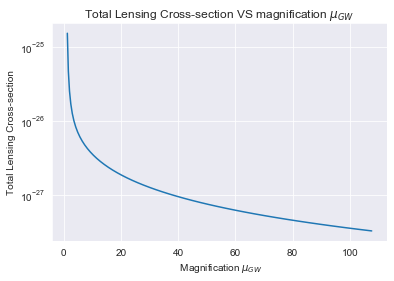

In [27]:
plt.plot(mu_z, cross_sec_mu)
plt.yscale("log")
#plt.xscale("log")
plt.title(r"Total Lensing Cross-section VS magnification $\mu_{GW}$")
plt.ylabel(r"Total Lensing Cross-section")
plt.xlabel(r" Magnification $\mu_{GW}$")
plt.savefig("cross_sec_vs_mu.pdf")